In [135]:
###############################################################################
# Digits Dataset: Logistische Regression
# Sidney Göhler 544131
#### IKT (M)
# Special Engineering SoSe20
# Prof. Dr. Andreas Zeiser
###############################################################################
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.gridspec as gridspec
# import seaborn as sns #pip install searborn
import logistische_regression as lr
import time

from sklearn.datasets import load_digits
from scipy.stats.kde import gaussian_kde

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
def confusion_mat(y_true, y_pred):
    tn = np.sum((y_true == y_pred) & (y_true == 0))
    tp = np.sum((y_true == y_pred) & (y_true == 1))
    fp = np.sum((y_true != y_pred) & (y_true == 0))
    fn = np.sum((y_true != y_pred) & (y_true == 1))
    
    return np.array([[tp, fp],[fn, tn]])

In [2]:
def root_means(y_true, y_pred):

    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    #mse2 = 1/(len(y_true))*np.sum((y_true - y_pred) ** 2)
    #print(mse,mse2)
    return rmse

In [71]:
def crossval(X, y, eta, k,  tol = 3e-4):
    #randomseed
    time_start = time.time()
    
    np.random.seed(0)
    
    train_folds_score = []
    validation_folds_score = []
    
   # print(type(eta))
    #eta = list(np.arange(0.5,0.77,0.05))
    counter_test= []
    rmse_test = []
    J_test = []
    counter_per_eta = []
    rmse_per_eta = []
    J_per_eta = []
    
    #shuffle index once
    m = X.shape[0]
    index = np.arange(m)
    np.random.shuffle(index)
    
    for i,e in enumerate(eta):
        time_start = time.time()
        for fold in range(0, k):
            
            start = int((m/k)*fold)
            end = int((m/k)*(fold+1))

            # X_train aufteilen in train und val
            val = X[index[start:end]]
            val_y = y[index[start:end]]
            
            train = np.concatenate((X[index[:start]], X[index[end:]]))
            train_y = np.concatenate((y[index[:start]], y[index[end:]]))
            #print(e,np.shape(train),np.shape(val))

            theta, J_tr, counter = lr.LogisticRegression_fit(train, train_y, e, tol)

            val_pred = lr.LogisticRegression_predict(val, theta)
            
            counter_test.append(counter)
            rmse = root_means(val_y, val_pred)
            rmse_test.append(rmse)
            J, Jgrad = lr.logistic_cost_function(val, val_y, theta)
            J_test.append(J)
            #print(f'for eta {e} fold {fold} took {counter} iterations in {time.time()-time_start} seconds ({counter/(time.time()-time_start)} iter/sec)\nrmse = {rmse}\nJ = {J}\n')
        
        rmse_m = np.mean(rmse_test)
        J_m = np.mean(J_test)
        counter_m = np.mean(counter_test)
        
        print(f'\n##CV {i}##\nfor eta {e} in {counter_m} iterations'
              + f' took {time.time()-time_start} seconds ({counter/(time.time()-time_start)} iter/sec):'
              + f'\nrmse mean = {rmse_m} | diff: {(rmse_m)-rmse_per_eta[-1] if len(rmse_per_eta)>0 else "0.0"}'
              + f'{" new min!" if len(rmse_per_eta)==0 or rmse_m < np.min(rmse_per_eta) else ""}'
              + f'\nJ mean = {J_m} | diff: {(J_m)-J_per_eta[-1] if len(J_per_eta)>0 else "0.0"}'
              + f'{" new min!" if len(J_per_eta)==0 or J_m < np.min(J_per_eta) else ""}'
              + '\n#########\n')
        
        counter_per_eta.append(counter_m)
        rmse_per_eta.append(rmse_m )
        J_per_eta.append(J_m)
        counter_test= []
        rmse_test = []
        J_test = []

        
    return eta, rmse_per_eta, J_per_eta, counter_per_eta

In [4]:
####################
# load datasets
####################
dataset = load_digits()
#print(dataset.DESCR, '\n', '\n')
X = dataset.data
y = dataset.target

targets = dataset.target_names
images = dataset.images



In [5]:
mean, std = lr.StandardScaler_fit(X)

X = lr.StandardScaler_transform(X, mean, std+10)

In [6]:
print(np.max(X),np.min(X))

1.3473056603822613 -0.8571148139579597


In [ ]:
for ind in [0,20,500,508,1700,1787]:
    print(f'digit = {y[ind]} at index = {ind}')
    plt.matshow(images[ind], cmap = cm.inferno)
    plt.colorbar()
    plt.show()
    print(f'{images[ind]}\n\n\n')

In [8]:
####################
# split dataset (80:20)
####################


X_train, X_test, y_train, y_test = lr.train_test_split(X, y, 0.8, 0)

print(np.shape(X_train),np.shape(y_train),'\n',np.shape(X_test),np.shape(y_test))

(1437, 64) (1437,) 
 (360, 64) (360,)


In [ ]:
####################
# explore trainingset
####################

# Häufigkeitsverteilung y (target)
fig = plt.figure(figsize=(9, 8))

labels, counts = np.unique(y_train, return_counts=True)

plt.bar(labels, counts, align='center', width=0.95)
plt.gca().set_xticks(labels)
plt.xlabel('digit')
plt.xlim(-1,10)
plt.ylabel('count')
plt.title('relative Häufigkeitsverteilung der digits der Trainingsdaten')
plt.grid(color='0.75', linestyle='-.', linewidth=1, axis='y')
plt.show()

In [ ]:
print(labels,counts)

In [ ]:
mean_train, std_train = [], []
coeffs = []



labels = np.arange(-1.4,1.5,0.2)
xmax = 1.4
xmin = -1.4

for ind, col in enumerate(X_train.T):

    # print(df[col].describe())
    mean, std = lr.StandardScaler_fit(col)
    mean_train.append(mean)
    std_train.append(std)
    print(f'feature {ind} ({ind}):')
    fig1 = plt.figure(figsize=(16, 6))
    gs = gridspec.GridSpec(1, 2)
    ax = plt.subplot(gs[0])
    ax.set_xlabel('black value')
    ax.set_ylabel("count")
    ax.set_title(f"Histogramm der Helligkeitswerte: feature {ind}")
    
    label, counts = np.unique(col, return_counts=True)

    ax.bar(label, counts, align='center', width=0.05)
    ax.set_xticks(labels)
    ax.set_xlim(xmin,xmax)
    ##
    ##
    
    # Verteilungsdichte bestimmen
    # random offset um die covarianz numerisch betimmen zu können
    rand = 0.0001*np.random.rand(np.size(col,0))-0.0001
    # KDE
    k = gaussian_kde(np.vstack([col+rand, y_train]))
    xi, yi = np.mgrid[xmin:xmax:col.size**0.75*1j, y_train.min()-0.5:y_train.max()+0.5:y_train.size**0.3333*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    ax2 = plt.subplot(gs[1])
    ax2.set_xlabel('black value')
    ax2.set_ylabel("digit")
    ax2.set_xticks(labels)
    ax2.set_yticks(targets)
    ax2.set_ylim(-0.5,9.5)
    ax2.set_xlim(xmin,xmax)
    #ax2.matshow([col,y_train])
    
    #plot density
    #ax2.scatter(col, y_train, alpha=0.1)#, c=col, cmap=cm.cividis)
    #im = ax2.pcolormesh(xedges, yedges, Z.T)
    im = ax2.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap = cm.inferno, alpha=1)#cm.cividis GnBu YlOrBr viridis magma
    plt.colorbar(im)
    
    ##
    coeff = np.mean(np.corrcoef(col, y_train.T))
    coeffs.append(coeff)
    ax2.set_title(f"Dichteverteilung der Helligkeitswerte feature {ind} je digit")
    plt.show()

    #Feature beschreiben
    print(f'rows = {np.size(col)}\nall numeric = {not np.isnan(col).any()} ({col.dtype})\nmean = {mean}\nstd = {std}\nmax|min = {np.max(col)}|{np.min(col)}', '\n', '\n')


In [9]:
#X_train_9 =X_train[y_train==9]
y_train_t = []
y_test_t = []


for tar in targets:
    y_train_t.append(np.array([1 if y == tar else 0 for y in y_train]))
    y_test_t.append(np.array([1 if y == tar else 0 for y in y_test]))
    print(f'digit {tar}: +{len(y_train_t[tar][y_train_t[tar]==1])}/{len(y_train_t[tar][y_train_t[tar]==0])}- train label || +{len(y_test_t[tar][y_test_t[tar]==1])}/{len(y_test_t[tar][y_test_t[tar]==0])}- test label')
    #[147 147 138 150 137 153 141 139 146 139]

digit 0: +147/1290- train label || +31/329- test label
digit 1: +147/1290- train label || +35/325- test label
digit 2: +138/1299- train label || +39/321- test label
digit 3: +150/1287- train label || +33/327- test label
digit 4: +137/1300- train label || +44/316- test label
digit 5: +153/1284- train label || +29/331- test label
digit 6: +141/1296- train label || +40/320- test label
digit 7: +139/1298- train label || +40/320- test label
digit 8: +146/1291- train label || +28/332- test label
digit 9: +139/1298- train label || +41/319- test label


### Bestimmung der Lernrate mittels CV

bluu

In [147]:
#############################################
# Kreuzvalidierung
etalist = np.arange(0.04,2.0,0.033)
print('CV with\n',etalist,'\n',len(etalist),'etas')

eta, rmse, J, counter = crossval(y_train_t[9],y_train_t[9], etalist, 5)

etas [0.04  0.073 0.106 0.139 0.172 0.205 0.238 0.271 0.304 0.337 0.37  0.403
 0.436 0.469 0.502 0.535 0.568 0.601 0.634 0.667 0.7   0.733 0.766 0.799
 0.832 0.865 0.898 0.931 0.964 0.997 1.03  1.063 1.096 1.129 1.162 1.195
 1.228 1.261 1.294 1.327 1.36  1.393 1.426 1.459 1.492 1.525 1.558 1.591
 1.624 1.657 1.69  1.723 1.756 1.789 1.822 1.855 1.888 1.921 1.954 1.987]

#######
for eta 0.04 in 187745.6 iterations took 225.2609405517578 seconds (833.6021306670101 iter/sec):
rmse mean = 0.0006808833622162374 | diff:0.0 new min!
J mean = 0.0006726926124389755 | diff:0.0 new min!
#######


#######
for eta 0.07300000000000001 in 102873.2 iterations took 114.36749267578125 seconds (899.6524938400478 iter/sec):
rmse mean = 0.0006808817490254984 | diff:-1.6131907390861192e-09 new min!
J mean = 0.0006726910032917533 | diff:-1.6091472222626649e-09 new min!
#######


#######
for eta 0.10600000000000001 in 70845.6 iterations took 77.77928280830383 seconds (911.013800096844 iter/sec):
rmse mean = 0.


#######
for eta 1.0630000000000004 in 7062.4 iterations took 7.721124649047852 seconds (914.8926252435406 iter/sec):
rmse mean = 0.0006808311226618015 | diff:2.9593634022278756e-09
J mean = 0.0006726410022157116 | diff:2.9890623411740064e-09
#######


#######
for eta 1.0960000000000003 in 6849.8 iterations took 7.723078012466431 seconds (887.081548178234 iter/sec):
rmse mean = 0.0006808170047874001 | diff:-1.411787440143246e-08 new min!
J mean = 0.0006726271722900781 | diff:-1.3829925633521145e-08 new min!
#######


#######
for eta 1.1290000000000002 in 6649.4 iterations took 7.167733192443848 seconds (927.7689084479823 iter/sec):
rmse mean = 0.000680830266630565 | diff:1.3261843164868309e-08
J mean = 0.0006726393615643317 | diff:1.2189274253577437e-08
#######


#######
for eta 1.1620000000000004 in 6460.6 iterations took 7.201924800872803 seconds (897.2601323491838 iter/sec):
rmse mean = 0.000680815525598808 | diff:-1.4741031756902202e-08 new min!
J mean = 0.0006726252554499523 | dif

In [148]:

eta_min_rmse = eta[np.argmin(rmse)]
eta_min_J = eta[np.argmin(J)]

print(eta_min_rmse,eta_min_J)

1.9870000000000005 1.8550000000000004


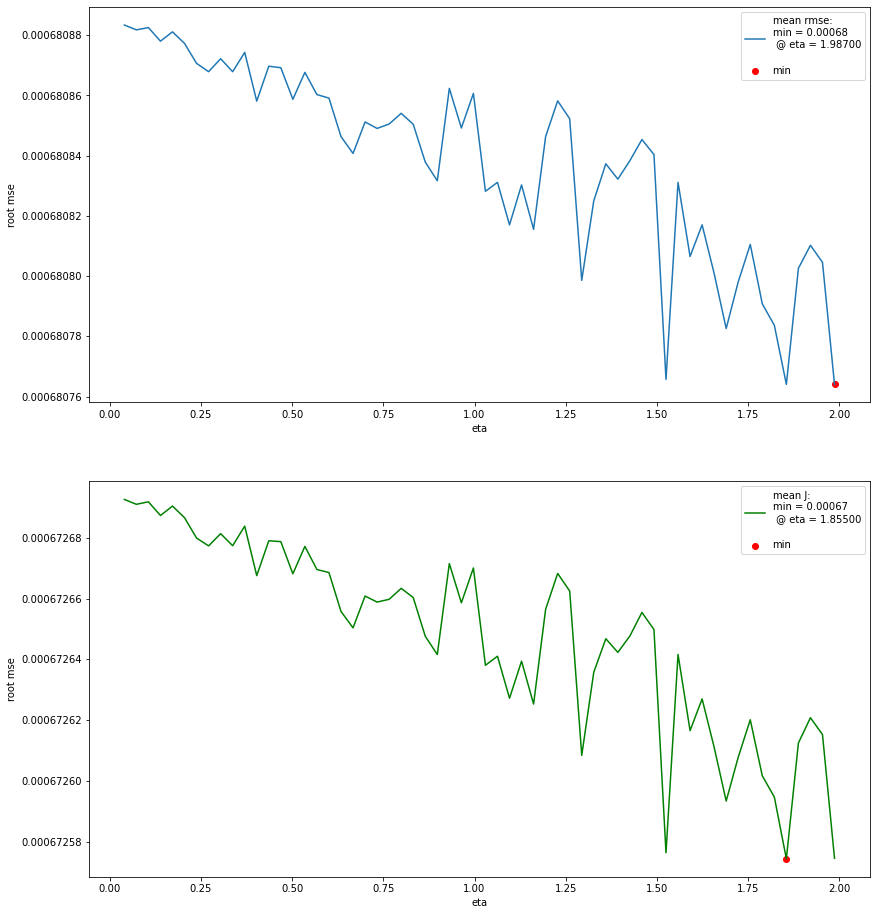

In [149]:
fig = plt.figure(figsize=(14, 16))
gs = gridspec.GridSpec(2, 1)
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
#print(np.size(eta),np.size(rmse))
ax.plot(eta, rmse, label=f'mean rmse:\nmin = {np.min(rmse):.5f}\n @ eta = {eta_min_rmse:.5f}\n')
#print(np.size(eta),np.size(J))
ax2.plot(eta, J, label=f'mean J:\nmin = {np.min(J):.5f}\n @ eta = {eta_min_J:.5f}\n', color='g')
ax.scatter(eta_min_rmse, np.min(rmse), color='r', marker='o', label='min')
ax2.scatter(eta_min_J, np.min(J), color='r', marker='o', label='min')


#plt.ylim(np.min(J)-0.00005,np.max(rmse)+0.00005)
#plt.xlim(min(eta_min_rmse, eta_min_J)-0.05, max(eta_min_rmse, eta_min_J)+0.05)
ax.set_xlabel('eta')
ax.set_ylabel('root mse')

ax2.set_xlabel('eta')
ax2.set_ylabel('root mse')

ax.legend()
ax2.legend()
#plt.title('RMSE und J über verschiedene eta')
plt.show()





### Logistische Regression für das gesamte Trainingset

test

In [136]:
X_train = np.float64(X_train)
thetas = []
Js = []
counters = []
for tar in targets:
    time_start = time.time()
    print(f'learning digit {tar}...')
    theta, Jt, counter = lr.LogisticRegression_fit(X_train, y_train_t[tar], eta_min_J, 3e-4)
    print('Calculating Thetas done... \n',theta,'\n cost =',Jt,'\n')
    thetas.append(theta)
    Js.append(Jt)
    counters.append(counter)
    print(f'took {counter} iterations in {time.time()-time_start} seconds ({counter/(time.time()-time_start)} iter/sec)...\n\n')


learning digit 0...
Calculating Thetas done... 
 [-1.16277507e+01  0.00000000e+00 -3.23626361e-01 -5.83131585e-02
  1.03271232e+00 -4.05282562e-01 -3.21971969e+00 -1.89361712e+00
 -2.33805919e-01  5.34108013e-04 -8.85220423e-01  4.38796927e-01
  1.69720379e+00  2.31855254e+00  3.02346987e+00 -1.39678399e-02
 -3.20481316e-01 -1.82692152e-02  8.25619281e-01  1.50245420e+00
  2.49166772e-02 -3.35404391e+00  3.50681936e+00  3.00730241e-01
 -1.52973763e-01 -8.81784764e-03  9.20723472e-01  2.73128013e-01
 -2.05430219e+00 -6.34770845e+00  1.09082583e-01  5.67952248e-01
 -1.96205122e-02  0.00000000e+00  1.31344275e+00  1.90191925e+00
 -1.44429431e+00 -5.07855804e+00 -4.79423480e-01  3.09970136e-01
  0.00000000e+00 -5.58455662e-02 -1.40502700e-01  3.36405923e+00
 -4.44521355e+00 -3.13708349e+00 -2.38053705e-02  6.46391914e-01
  1.51878759e-02 -1.58173900e-01 -1.14550302e+00  1.08505542e+00
 -3.44418289e-01  9.36710552e-01 -6.97343615e-01 -2.16728097e+00
 -7.23947057e-01 -2.19398702e-04 -4.48658

Calculating Thetas done... 
 [-1.22407781e+01  0.00000000e+00 -1.82474061e+00  5.80803063e-01
  2.58909163e+00  1.97988679e+00  2.50948925e+00  1.52855050e+00
  1.89579264e+00  6.69904619e-04 -2.32280075e+00 -3.04039212e-01
 -2.18250843e-01  7.72069824e+00  1.19877436e+00 -9.29009328e-01
  3.55089374e+00  1.14066124e-03 -1.84777276e+00 -4.00595495e+00
 -4.33343173e+00 -2.84697671e+00 -5.36327706e-01  1.72311803e+00
  2.11520117e-01  9.92280734e-04 -5.84073789e+00 -3.96366214e-01
 -2.82655591e+00 -6.33778351e-03  1.74419275e+00  2.00814100e+00
 -2.17305731e-01  0.00000000e+00  2.39078366e+00 -4.89577652e-01
  1.01216792e+00  8.90609388e-01  1.89799740e+00  3.85705094e+00
  0.00000000e+00 -6.65836174e-03 -3.22061302e+00  8.57959022e-01
  1.84686297e+00  2.11627010e+00  2.37912930e+00 -3.12392157e-01
  1.81772342e-02  2.20381876e-03 -2.38822081e-01  4.79840340e-01
  3.39336857e-01 -7.89310593e+00 -7.45380605e+00 -6.63209512e-01
  8.64438545e-02 -4.56080546e-04 -2.74142306e+00 -3.36925275e

In [ ]:
from sklearn.metrics import precision_recall_curve

for tar in targets:
    print(f'digit = {tar}')
    #tar = 0
    y_pred = lr.LogisticRegression_predict(X_test, thetas[tar])
    #print(y_pred)
    #print(y_test_t[tar])
    acc = lr.accuracy_score(y_pred,y_test_t[tar])
    precision = lr.precision_score(y_pred,y_test_t[tar])
    recall = lr.recall_score(y_pred,y_test_t[tar])
    

    
    
    fig1 = plt.figure(figsize=(16, 6))
    gs = gridspec.GridSpec(1, 2)
    ax = plt.subplot(gs[0])
    ax.set_xlabel('precision')
    ax.set_ylabel("recall")
    #ax.set_title(f"relative Häufigkeitsverteilung feature {ind} je Helligkeitswert")
    print('Accuracy: ',acc,'\nPrecision: ',precision,'\nRecall: ', recall,'\n\n')


### Lernkurven und andere Kennzahlen

blaa

In [83]:
over = range(1,1400,20)
time_start = time.time()
thetas_lc = []
Js_lc = []
Js_te = []
counters_lc = []

print(f'learning digit {tar}...')

for d in over:
    X_train_lc = X_train[:d]
    y_train_lc = y_train_t[9][:d]
    
    

    theta, J, counter = lr.LogisticRegression_fit(X_train_lc, y_train_lc, eta_min_J, 3e-4)

    print(f'Calculating for {d} samples done... \n cost =',J,' diff:',J-Js_lc[-1] if len(Js_lc)>0 else False ,'\n')
    thetas_lc.append(theta)
    Js_lc.append(J)
    counters_lc.append(counter)
    if d > 777:
         if np.all(Js_lc[-3] <= J):
            print("Kosten bleibt gleich oder steigt")
            break

            
            
print(f'took {np.sum(counters_lc)} iterations in {time.time()-time_start} seconds ({np.sum(counters_lc)/(time.time()-time_start)} iter/sec)...\n\n')



learning digit 9...
Calculating for 1 samples done... 
 cost = 0.00011675496085504759  diff: False 

Calculating for 21 samples done... 
 cost = 0.00040314545540685664  diff: 0.00028639049455180904 

Calculating for 41 samples done... 
 cost = 0.0005294636903230393  diff: 0.00012631823491618264 

Calculating for 61 samples done... 
 cost = 0.0008340085247410471  diff: 0.0003045448344180078 

Calculating for 81 samples done... 
 cost = 0.0009440608321861888  diff: 0.00011005230744514174 

Calculating for 101 samples done... 
 cost = 0.0010219122051098285  diff: 7.785137292363965e-05 

Calculating for 121 samples done... 
 cost = 0.0014379897662360644  diff: 0.0004160775611262359 

Calculating for 141 samples done... 
 cost = 0.001577962234074352  diff: 0.00013997246783828757 

Calculating for 161 samples done... 
 cost = 0.00162037088136123  diff: 4.240864728687803e-05 

Calculating for 181 samples done... 
 cost = 0.0017643196621755397  diff: 0.00014394878081430977 

Calculating for 20

In [88]:
print(Js_lc)
over = range(1,d+20,20)

[0.00011675496085504759, 0.00040314545540685664, 0.0005294636903230393, 0.0008340085247410471, 0.0009440608321861888, 0.0010219122051098285, 0.0014379897662360644, 0.001577962234074352, 0.00162037088136123, 0.0017643196621755397, 0.0020464268688248953, 0.002199301850086385, 0.0022643136391778834, 0.0024374925191206426, 0.002501382932590295, 0.0025251701630594112, 0.0030183488629774474, 0.0031218970347321015, 0.003146608325747083, 0.003257115076482781, 0.0032552613579028087, 0.0032882254929377653, 0.00397243024222728, 0.004333526879623892, 0.004322925022902483, 0.0043091929836228835, 0.004402651265853669, 0.0043889479152908984, 0.00438354647210744, 0.004379882509658502, 0.004723376674097633, 0.0047205362155295525, 0.005136635646182586, 0.005324595461807105, 0.005314106425268202, 0.0053058616449400235, 0.005302594781252324, 0.005300983416907196, 0.0052746773122851, 0.005856766385123873]


In [90]:
print(len(thetas_lc))


Js_le = []
rmse_tr = []
rmse_te = []
acc_tr = []
acc_te = []
prec_tr = []
prec_te = []
rec_tr = []
rec_te = []
h_tr = []
h_te = []

for theta in thetas_lc:
    
    y_pred_tr, h = lr.LogisticRegression_predict(X_train, theta)
    y_pred_te, h_ = lr.LogisticRegression_predict(X_test, theta)
    J_te, Jgrad = lr.logistic_cost_function(X_test, y_test_t[9], theta)
    Js_le.append(J_te)
    rmse_tr.append(root_means(y_train_t[9],y_pred_tr))
    rmse_te.append(root_means(y_test_t[9],y_pred_te))
    acc_tr.append(lr.accuracy_score(y_train_t[9],y_pred_tr))
    acc_te.append(lr.accuracy_score(y_test_t[9],y_pred_te))
    prec_tr.append(lr.precision_score(y_train_t[9],y_pred_tr))
    prec_te.append(lr.precision_score(y_test_t[9],y_pred_te))
    rec_tr.append(lr.recall_score(y_train_t[9],y_pred_tr))
    rec_te.append(lr.recall_score(y_test_t[9],y_pred_te))
    h_tr.append(h)
    h_te.append(h_)

40


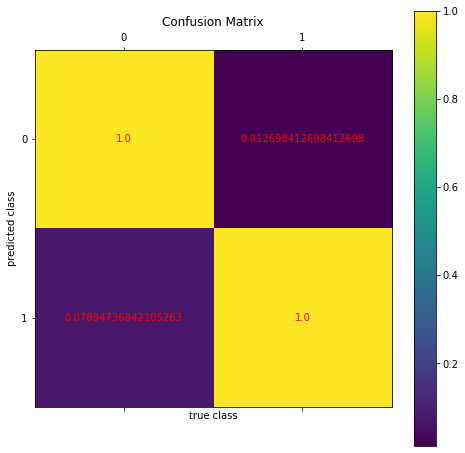

In [126]:
mat = confusion_mat(y_test_t[9],y_pred_te)

mat = mat / np.max(np.abs(mat),axis=0) 

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Confusion Matrix')
ax.set_xlabel('true class')
ax.set_ylabel('predicted class')


for i in range(2):
    for j in range(2):
        text = ax.text(j, i, mat[i, j],
                       ha="center", va="center", color="r")
cax = ax.matshow(mat)
fig.colorbar(cax)
plt.show()

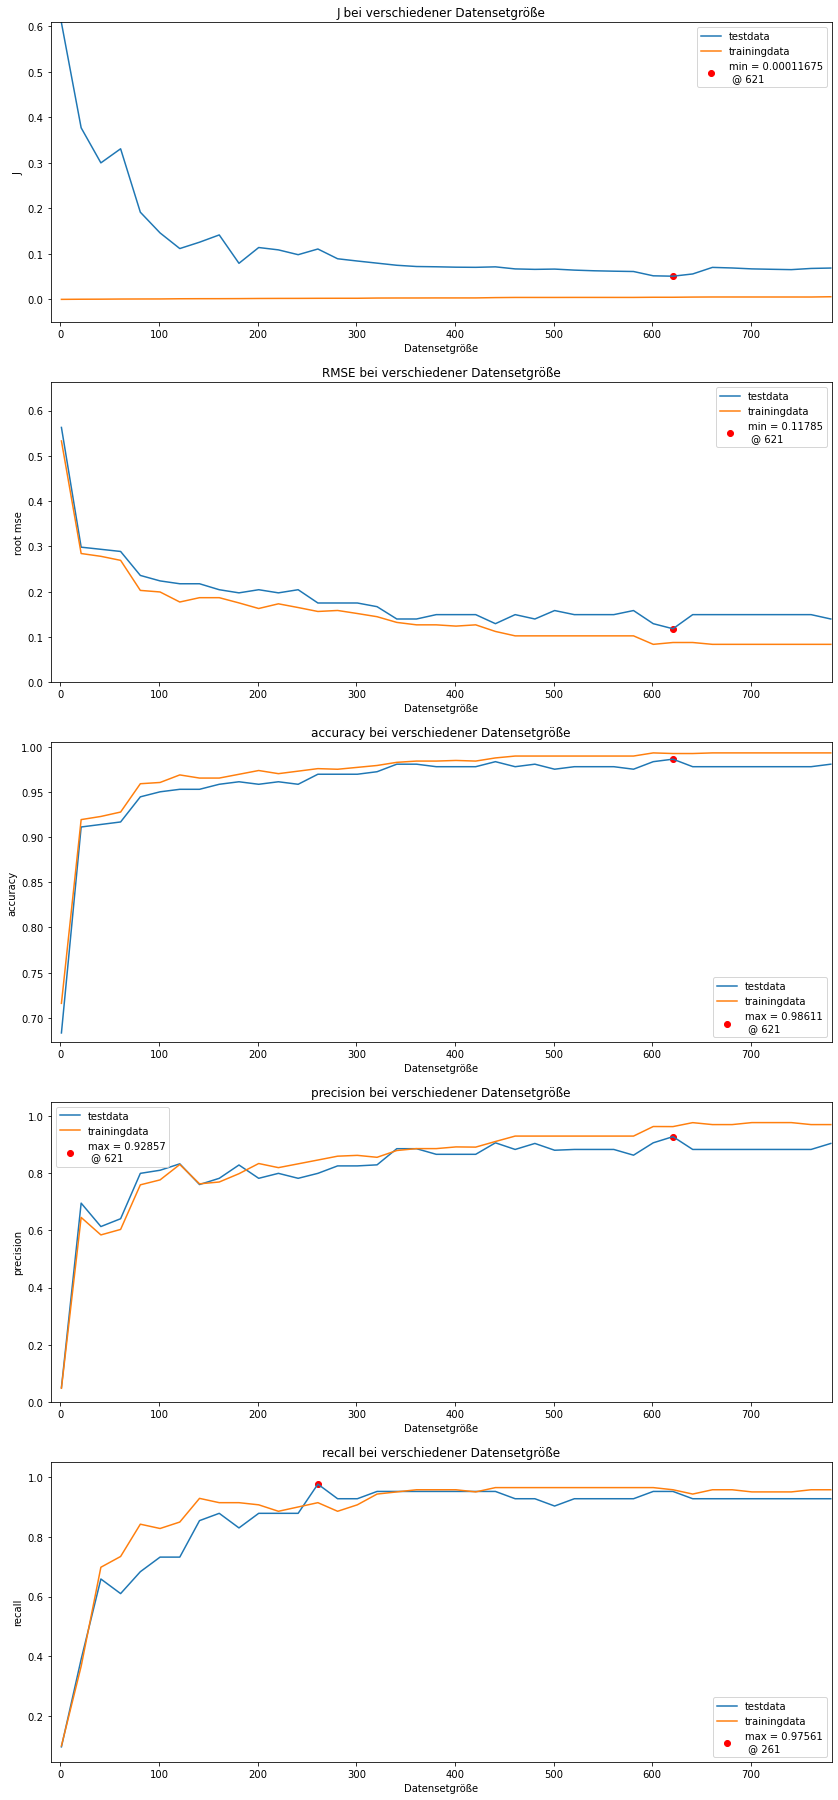

In [133]:

overmin_J = over[np.argmin(Js_lc)]
overmin_te = over[np.argmin(rmse_te)]
overmin_tr = over[np.argmax(acc_te)]
overmin_prec = over[np.argmax(prec_te)]
overmin_rec = over[np.argmax(rec_te)]
text = "Datensetgröße"

fig = plt.figure(figsize=(14, 32))
gs = gridspec.GridSpec(5, 1)
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[1])

ax.set_title(f'J bei verschiedener {text}')
ax.plot(over, Js_le, label='testdata')
ax.plot(over, Js_lc, label='trainingdata')
#ax.scatter(overmin_tr, np.min(Js_le), color='r', marker='o', label='min')
ax.scatter(overmin_te, np.min(Js_le), color='r', 
           marker='o', label=f'min = {np.min(Js_lc):.5}\n @ {overmin_te}')
ax.set_ylabel('J')
ax.set_xlabel(f'{text}')
ax.set_ylim(-0.05,max(Js_le)+0.001)
ax.set_xlim(-10,max(over)+1)
ax.legend()


ax5.set_title(f'RMSE bei verschiedener {text}')
ax5.plot(over, rmse_te, label='testdata')
ax5.plot(over, rmse_tr, label='trainingdata')
#ax.scatter(overmin_tr, np.min(np.sqrt(mse_train)), color='r', marker='o', label='min')
ax5.scatter(overmin_te, np.min(rmse_te), color='r', 
           marker='o', label=f'min = {np.min(rmse_te):.5}\n @ {overmin_te}')
ax5.set_ylabel('root mse')
ax5.set_xlabel(f'{text}')
ax5.set_ylim(0,max(rmse_te)+0.1)
ax5.set_xlim(-10,max(over)+1)
ax5.legend()

ax2.set_title(f'accuracy bei verschiedener {text}')
ax2.plot(over, acc_te, label='testdata')
ax2.plot(over, acc_tr, label='trainingdata')
#ax2.scatter(overmin_tr, np.min(np.sqrt(mse_train)), color='r', marker='o')
ax2.scatter(overmin_tr, np.max(acc_te), color='r',
            marker='o', label=f'max = {np.max(acc_te):.5}\n @ {overmin_tr}')

ax2.set_ylabel('accuracy')
ax2.set_xlabel(f'{text}')
# ax2.set_xlim(110,160)
# ax2.set_ylim(2.75,3.7)
ax2.set_ylim(min(acc_te)-0.01,1.005)
ax2.set_xlim(-10,max(over)+1)
ax2.legend()

ax3.set_title(f'precision bei verschiedener {text}')
ax3.plot(over, prec_te, label='testdata')
ax3.plot(over, prec_tr, label='trainingdata')
#ax2.scatter(overmin_tr, np.min(np.sqrt(mse_train)), color='r', marker='o')
ax3.scatter(overmin_tr, np.max(prec_te), color='r',
            marker='o', label=f'max = {np.max(prec_te):.5}\n @ {overmin_prec}')
ax3.set_ylabel('precision')
ax3.set_xlabel(f'{text}')
# ax2.set_xlim(110,160)
# ax2.set_ylim(2.75,3.7)
ax3.set_ylim(min(prec_te)-0.05,1.05)
ax3.set_xlim(-10,max(over)+1)
ax3.legend()

ax4.set_title(f'recall bei verschiedener {text}')
ax4.plot(over, rec_te, label='testdata')
ax4.plot(over, rec_tr, label='trainingdata')
#ax2.scatter(overmin_tr, np.min(np.sqrt(mse_train)), color='r', marker='o')
ax4.scatter(overmin_rec, np.max(rec_te), color='r',
            marker='o', label=f'max = {np.max(rec_te):.5}\n @ {overmin_rec}')
ax4.set_ylabel('recall')
ax4.set_xlabel(f'{text}')
# ax2.set_xlim(110,160)
# ax2.set_ylim(2.75,3.7)
ax4.set_ylim(min(rec_te)-0.05,1.05)
ax4.set_xlim(-10,max(over)+1)
ax4.legend()

#plt.savefig(f'learncurve_{text}.png')
plt.show()
